In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib import font_manager
import matplotlib.patches as patches
import geopandas as gpd
from scipy.stats import rankdata

#for paths
import os

#set root folder
project_root = os.path.abspath(os.getcwd())

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Setup 

In [3]:
#dictionary of London boroughs and their ONS codes
pos_dict = {'E09000001': 29,  'E09000002': 32, 'E09000003': 12, 'E09000004': 40,  'E09000005': 19, 'E09000006': 46,
           'E09000007': 20, 'E09000008': 45,  'E09000009': 18,  'E09000010': 5,  'E09000011': 39,  'E09000012': 22,
           'E09000013': 26,  'E09000014': 13,  'E09000015': 11,  'E09000016': 24, 'E09000017': 17,  'E09000018': 25,
           'E09000019': 21,  'E09000020': 27,  'E09000021': 43, 'E09000022': 36,  'E09000023': 38,  'E09000024': 44,
           'E09000025': 31,  'E09000026': 23,  'E09000027': 34,  'E09000028': 37,  'E09000029': 52,  'E09000030': 30,
           'E09000031': 14,  'E09000032': 35,  'E09000033': 28}

display_dict = {'E09000007': 'CMD', 'E09000001': 'CTY', 'E09000012': 'HCK', 'E09000013': 'HMS', 'E09000014': 'HGY',
             'E09000019': 'ISL', 'E09000020': 'KNS', 'E09000022': 'LAM', 'E09000023': 'LSH', 'E09000025': 'NWM',
             'E09000028': 'SWR', 'E09000030': 'TOW', 'E09000032': 'WNS', 'E09000033': 'WST', 'E09000002': 'BAR',
             'E09000003': 'BRN', 'E09000004': 'BXL',  'E09000005': 'BRT',  'E09000006': 'BRM',  'E09000008': 'CRD',
             'E09000009': 'ELG',  'E09000010': 'ENF',  'E09000011': 'GRN',  'E09000015': 'HRW',  'E09000016': 'HVG',
             'E09000017': 'HDN',  'E09000018': 'HNS',  'E09000021': 'KNG',  'E09000024': 'MRT',  'E09000026': 'RDB',
             'E09000027': 'RCH',  'E09000029': 'STN',  'E09000031': 'WTH'}

# Data preparation

In [5]:
#load data
#read in each tab and merge into one table
df_any = pd.read_excel(os.path.join(project_root, "raw_data\\cw0302.xlsx"), sheet_name="CW0302_Any_Purpose", skiprows=7)
df_leisure = pd.read_excel(os.path.join(project_root, "raw_data\\cw0302.xlsx"), sheet_name="CW0302_Leisure", skiprows=7)
df_travel = pd.read_excel(os.path.join(project_root, "raw_data\\cw0302.xlsx"), sheet_name="CW0302_Travel", skiprows=7)
df = pd.concat([df_any, df_leisure, df_travel])

In [6]:
# filter for London boroughs and London wide
area_filter = list(pos_dict.keys())
for area in ["E92000001", "E12000007", "E13000001", "E13000002"]:
    area_filter.append(area)
    
df = df[df["ONS Code"].isin(area_filter)]

In [7]:
df

,ONS Code,Area name,Mode,Purpose,Frequency,2021,2020,2019,2018,2017,2016
0,E92000001,England,Cycling,Any,At least once per month,13.148585,16.0952,16.05838,16.0966,16.8774,17.1082
1,E92000001,England,Cycling,Any,At least once per week,9.146141,11.6155,11.220882,11.4848,11.8555,11.903
2,E92000001,England,Cycling,Any,At least 3 times per week,3.948726,5.3087,5.320626,5.5048,5.6748,5.6702
3,E92000001,England,Cycling,Any,At least 5 times per week,2.145250,2.9789,3.170456,3.3369,3.3673,3.3718
840,E12000007,London,Cycling,Any,At least once per month,16.876291,18.3318,17.690567,17.0717,17.3157,17.4828
...,...,...,...,...,...,...,...,...,...,...,...
979,E09000029,Sutton,Cycling,Travel,At least 5 times per week,0.388931,0.306,2.169984,0.4626,1.0211,1.3188
980,E09000031,Waltham Forest,Cycling,Travel,At least once per month,13.318614,14.6806,11.581433,11.1866,11.8133,11.6975
981,E09000031,Waltham Forest,Cycling,Travel,At least once per week,7.838100,9.6356,9.148015,8.4662,10.1178,8.7206
982,E09000031,Waltham Forest,Cycling,Travel,At least 3 times per week,2.989687,4.725,4.918454,3.8966,6.2883,4.2508


In [239]:
df.to_csv("cycling_rates_london_2016-2021.csv", index=False)

# Tile grip map

In [123]:
# customise colours
colors = {"line": "#1e6091", "area": "#76c893", "value": "#1e6091", "title":"#111111", "background": "#f9f9f9"}

#set fonts
label_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Ubuntu-R.ttf')
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Ubuntu-B.ttf')
annot_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Raleway-SemiBold.ttf')

#select data to plot
frequency = "At least once per week"
purpose = "Any"

#customise text
main_title = "London cycling rates"
title_fontsize = 22
subtitle = "Proportion of people cycling for any purpose at least once a week, 2016-2021 (%)"
footer = "Source: Active Lives Survey | Design: Lisa Hornung"

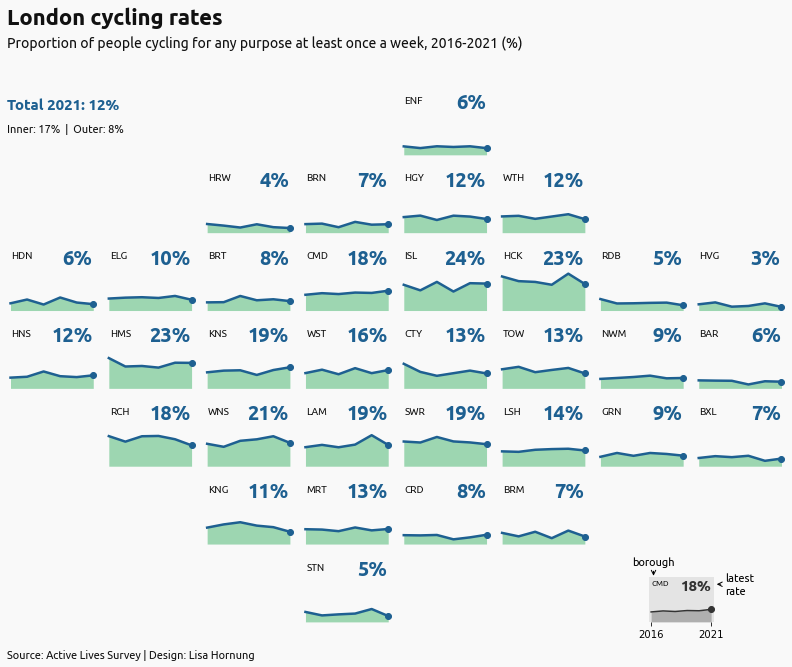

In [124]:
#========= Data
#filter data set based on input
data = df[(df["ONS Code"].isin(pos_dict.keys())) & (df["Frequency"] == frequency) & 
          (df["Purpose"]==purpose)].reset_index()
data["Display name"] = data["ONS Code"].map(display_dict)
data["pos"] = data["ONS Code"].map(pos_dict)

# ========= Layout
# Initialise Figure and define layout
fig,ax = plt.subplots(7,8,figsize=(12,9), sharey=True)

fig.set_facecolor(colors["background"])
plt.subplots_adjust(wspace=0.1, hspace=0.1, left=0.05, right=0.95, bottom=0.05)

#Format grid layout - remove frame + axis labels
for a in ax:
    for i in a:
        i.get_xaxis().set_visible(False)
        i.get_yaxis().set_visible(False)
        i.set_ylim(ymax=60, ymin=0)   
        i.axis('off')
        for pos in ["top", "bottom", "right", "left"]:
            i.spines[pos].set_visible(False)

#=========== Plotting
# plotting boroughs
y_values = ['2016', '2017', '2018','2019', '2020', '2021']        
x_values = [1,2,3,4,5,6]
height = max(data[y_values].max()) + 30

## Loop through all boroughs and map their values
for i in range(len(data)):
    plt.subplot(7,8,data["pos"][i])
    
    #display name of borough
    plt.text(1.05, height-10, data["Display name"][i], fontsize=10, ha="left", va='top', color="#111111",
            fontproperties=label_font)
    
    #plot area chart
    plt.fill_between(x_values,list(data.loc[i][y_values].values), zorder=1,color=colors["area"], alpha=0.7,
                    linewidth=0)    
    plt.plot(x_values,list(data.loc[i][y_values].values), zorder=2, 
             color=colors["line"],linewidth=2.5)    
    
    #plot last value dot
    plt.scatter(max(x_values),list(data.loc[i][y_values].values)[-1], zorder=3,color=colors["line"])
    
    #display most recent % value
    plt.text(max(x_values)-0.05, height-7, '{:,.0f}%'.format(list(data.loc[i][y_values].values)[-1]), 
             fontproperties=title_font, ha="right", fontsize=20, fontweight='bold', va='top', color=colors["value"])
    
    #set background colour
    plt.gca().set_xlim(xmin=0.8, xmax=6.2)
    plt.gca().set_ylim(ymax=height, ymin=0) 
    plt.gca().set_facecolor(colors["background"])
    for pos in ["top", "bottom", "right", "left"]:
         plt.gca().spines[pos].set_visible(False)

#============= Legend           
#add legend
plt.subplot(11,11,120)
plt.text(1.05,height-3,data["Display name"][0], fontsize=8, ha="left", va='top', color="#111111",fontproperties=label_font)
plt.fill_between(x_values,list(data.loc[0][y_values].values), zorder=1,color="#999999", alpha=0.7,linewidth=0)    
plt.plot(x_values,list(data.loc[0][y_values].values), zorder=2,color="#333333",linewidth=1.5)    
plt.scatter(max(x_values),list(data.loc[0][y_values].values)[-1], zorder=3,color="#333333")
plt.text(max(x_values)-0.05, height-2, '{:,.0f}%'.format(list(data.loc[0][y_values].values)[-1]), 
        fontproperties=title_font, ha="right", fontsize=15, fontweight='bold', va='top', color="#333333")
plt.gca().set_xlim(xmin=0.8, xmax=6.2)
plt.gca().set_ylim(ymax=height, ymin=0) 
plt.gca().set_facecolor("#E4E4E4")
for pos in ["top", "bottom", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)
plt.gca().set_xticks([1,6], ["2016", "2021"],fontsize = 10)
plt.gca().set_yticks([])
plt.gca().annotate('latest\nrate', xy=(max(x_values)+0.3, height-10), xycoords='data', xytext=(10, 0), textcoords='offset points', 
                   fontsize=11, fontproperties=label_font,ha='left', va='center', annotation_clip=False,
                    arrowprops=dict(arrowstyle="->",facecolor='black'))
plt.gca().annotate('borough', xy=(min(x_values)+0.2, height-1), xycoords='data', xytext=(0, 16), textcoords='offset points', 
                   fontsize=11, fontproperties=label_font,ha='center', va='center', annotation_clip=False,
                    arrowprops=dict(arrowstyle="->",facecolor='black'))

#=============== Text           
## Add titles and footer
y_pos = 1.0
x_pos = 0.05

fig.text(x_pos, y_pos, main_title, fontsize=title_fontsize, ha='left',va="top",
             fontweight="bold",  fontproperties=title_font, color=colors["title"])
fig.text(x_pos, y_pos-(title_fontsize*0.2*0.01), subtitle, fontsize=14, ha='left',va="top",
             fontweight="normal",  fontproperties=label_font, color="#111111")
fig.text(x_pos, 0, footer, fontsize=11, ha='left',va="center",
             fontweight="normal",  fontproperties=label_font, linespacing=1.5, color="#111111")

#============ London wide stats
inner = df[(df["Area name"]=="Inner London") & (df["Frequency"]==frequency) & (df["Purpose"]==purpose)]["2021"].iloc[0]
outer = df[(df["Area name"]=="Outer London") & (df["Frequency"]==frequency) & (df["Purpose"]==purpose)]["2021"].iloc[0]
london = df[(df["Area name"]=="London") & (df["Frequency"]==frequency) & (df["Purpose"]==purpose)]["2021"].iloc[0]

fig.text(x_pos, y_pos-0.14,  "Total 2021: " + '{:,.0f}%'.format(london), fontsize=15, ha='left',va="top",
         fontweight="bold",fontproperties=title_font, color=colors["value"])
fig.text(x_pos, y_pos-0.18, "Inner: " + '{:,.0f}%'.format(inner) + "  |  Outer: " + '{:,.0f}%'.format(outer) , 
         fontsize=11, ha='left',va="top", fontweight="regular",fontproperties=label_font, color="#111111")

# ==========
#save
plt.savefig("London-cycling-rates-2016-2021-tile-grid-map.png", bbox_inches='tight',  transparent=False, pad_inches=0.15)

plt.show()

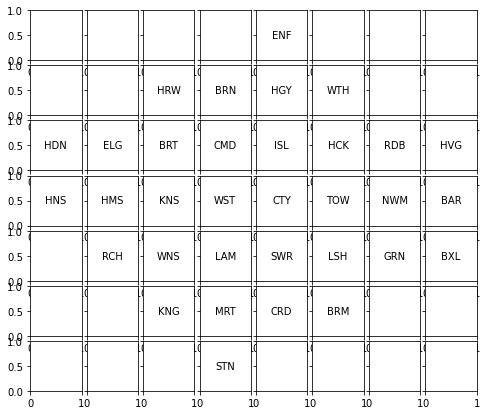

In [241]:
#filter data set based on input
data = df[(df["ONS Code"].isin(pos_dict.keys())) & (df["Frequency"] == frequency) & 
          (df["Purpose"]==purpose)].reset_index()

data["Display name"] = data["ONS Code"].map(display_dict)
data["pos"] = data["ONS Code"].map(pos_dict)

#===== Plotting
#initialise figure and define grid (7 rows, 8 columns)
fig,ax = plt.subplots(7,8, figsize=(8,7), sharey=True) #

#set padding around subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1) 

#loop through dataframe
for i in range(len(data)):
    
    #find correct subplot position
    plt.subplot(7,8,data["pos"][i])
    
    #display name of borough (set x + y pos to move around)
    plt.text(0.5,0.5, data["Display name"][i], fontsize=10, 
             ha='center', va='center')

    #code for plotting data in each tile below 
    # ---> 
    
plt.show()


# Charts

In [29]:
font_r = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Ubuntu-R.ttf')
font_m = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Ubuntu-M.ttf')
font_b = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Ubuntu-B.ttf')

## Trend over time

In [161]:
_filter = (df["Area name"].isin(["London", "Inner London", "Outer London"])) & (df["Frequency"]=="At least once per month")
pivot = df[_filter].reset_index(drop=True).replace(0, np.nan)
pivot

,ONS Code,Area name,Mode,Purpose,Frequency,2021,2020,2019,2018,2017,2016
0,E12000007,London,Cycling,Any,At least once per month,16.876291,18.3318,17.690567,17.0717,17.3157,17.4828
1,E13000001,Inner London,Cycling,Any,At least once per month,23.486784,25.2059,23.275092,NaN,NaN,NaN
2,E13000002,Outer London,Cycling,Any,At least once per month,12.226807,13.4930,13.770006,NaN,NaN,NaN
3,E12000007,London,Cycling,Leisure,At least once per month,10.711222,13.6831,12.979628,12.7020,12.4455,13.1815
4,E13000001,Inner London,Cycling,Leisure,At least once per month,13.838812,17.6118,15.850961,NaN,NaN,NaN
5,E13000002,Outer London,Cycling,Leisure,At least once per month,8.511435,10.9176,10.963837,NaN,NaN,NaN
6,E12000007,London,Cycling,Travel,At least once per month,11.422672,11.2046,11.019991,10.8873,10.6214,10.8272
7,E13000001,Inner London,Cycling,Travel,At least once per month,18.311416,18.0443,16.579122,NaN,NaN,NaN
8,E13000002,Outer London,Cycling,Travel,At least once per month,6.577482,6.3901,7.117258,NaN,NaN,NaN


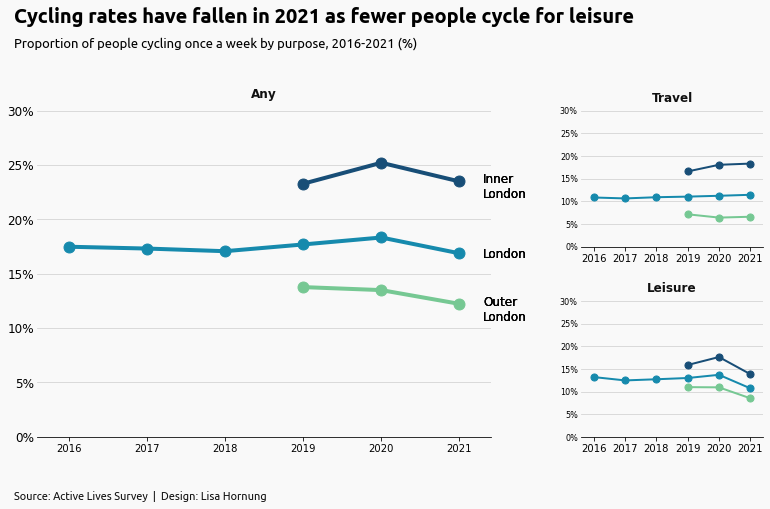

In [336]:
clr = {"London": "#168aad" , "Inner London": "#184e77", "Outer London": "#76c893" }
lines = {"Any":4, "Travel": 2, "Leisure": 2}
circle = {"Any":120, "Travel": 50, "Leisure": 50}

# create objects
fig = plt.figure(figsize=(13,6))
gs = GridSpec(2, 3, figure=fig)
fig.set_facecolor("#f9f9f9")

# create sub plots as grid
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1,2])
axes = [ax1, ax2,ax3]

#adjust subplots
fig.subplots_adjust(wspace=0.5, hspace=0.4) 

num = 0
for purpose in ["Any", "Travel", "Leisure"]:
    ax = axes[num]       
    data = pivot[pivot["Purpose"] == purpose]
    years = ['2016', '2017', '2018','2019', '2020', '2021']  
    
    for area in ["London", "Inner London", "Outer London"]:
        x = years
        y = data[data["Area name"]==area][years].iloc[0]
        ax.plot(x, y, color = clr[area], linewidth=lines[purpose], zorder=2, label=area)
        ax.scatter(x,y, s=circle[purpose], color=clr[area],  zorder=3)
    
    #xaxis
    ax.set_xlim(xmin=-0.4, xmax=5.4)
        
    #yaxis
    ax.set_ylim(ymin=0, ymax=30)
    ax.set_yticks(np.arange(0,31,5))
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:,.0f}%'.format(x)))
    ax.grid(visible=True, axis='y', zorder=1, color = "#D3D3D3")
    
    if num == 0:
        ax.tick_params(axis='y', length = 0, color = "#444444", labelsize=12)
    else:
        ax.tick_params(axis='y', length = 0, color = "#444444", labelsize=8)
        
    #remove frame
    for pos in ["top", "left", "right"]:
        ax.spines[pos].set_visible(False)
        
    
    ax.set_title(purpose,x=0.5, y=1.02, fontsize=12, color="#111111", fontweight='bold')
        
    ax.set_facecolor("#f9f9f9")
    
    num+=1
    
    #direct labels
    ax1.text(5.3 , 11.7, "Outer\nLondon", fontsize=12, va="center")
    ax1.text(5.3 , 16.8, "London", fontsize=12, va="center")
    ax1.text(5.3 , 23, "Inner\nLondon", fontsize=12, va="center")

#======
#Title, footer, notes
plt.figtext(0.1,1.12, "Cycling rates have fallen in 2021 as fewer people cycle for leisure", 
            fontproperties=font_b, va='top', fontsize=20)
plt.figtext(0.1,1.05, "Proportion of people cycling once a week by purpose, 2016-2021 (%)", 
            fontproperties=font_r, va='top', fontsize=13)
plt.figtext(0.1 , 0, "Source: Active Lives Survey  |  Design: Lisa Hornung", 
            fontproperties=font_r, color="#111111", fontsize=11, va="top")


#======
#save
plt.savefig("London-cycling-rates_2016-2021_trendlines.png", bbox_inches='tight',  transparent=False, pad_inches=0.15)


plt.show()

## 2021 all boroughs

In [106]:
_filter = (df["Purpose"] == "Any")  & (df["ONS Code"].isin(pos_dict.keys()))
freq_labels = { 'At least once per month': 'Once per month','At least once per week': 'Once per week',
               'At least 3 times per week':'Three times per week', 'At least 5 times per week': 'Five times per week'}
pivot = df[_filter].pivot(index="Area name", columns="Frequency", values="2021")
pivot.columns = pivot.columns.map(freq_labels)
pivot = pivot[freq_labels.values()]
pivot.head()

Frequency,Once per month,Once per week,Three times per week,Five times per week
Area name,,,,
Barking and Dagenham,9.076833,5.890696,2.450131,1.226283
Barnet,10.887653,7.465348,3.243043,2.017456
Bexley,10.208926,6.736248,1.421367,0.566370
Brent,12.213515,8.316184,3.746967,2.037506
Bromley,10.706280,6.676406,3.387396,3.336209


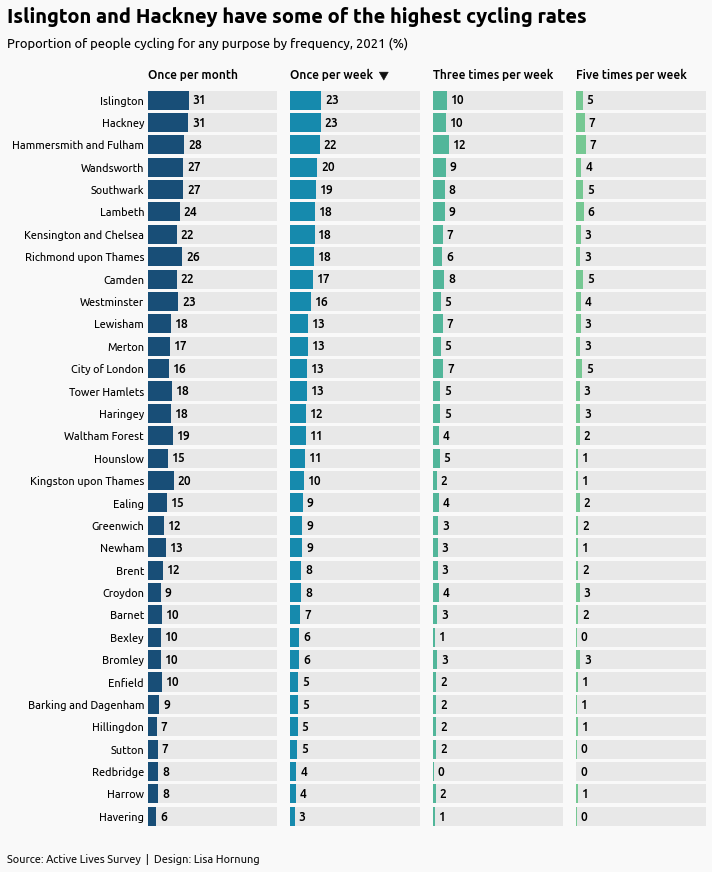

In [107]:
#ALL BOROUGHS

data = pivot.sort_values(by="Once per week", ascending=True)

#colr = {"Once per month": "#313167", "Once per week": "#747b74", 
       # "Three times per week":"#b66e56", "Five times per week": "#a33a36"}

colr = {"Once per month": "#184e77", "Once per week": "#168aad", 
        "Three times per week":"#52b69a", "Five times per week": "#76c893"}

###plot
fig, ax = plt.subplots(figsize=(10,14), sharey=True)
fig.set_facecolor("#f9f9f9")

#adjust subplots
plt.subplots_adjust(wspace=0.1, hspace=0.0) 

#title

y = np.arange(len(data))

num = 0
for column in data.columns:
    num+=1
    plt.subplot(1,4,num)
    
    plt.barh(y, data[column],height=0.85, color=colr[column],zorder=3, linewidth=0)
    plt.barh(y, 100,height=0.85, color='#e8e8e8',zorder=2,linewidth=0 )
    
    #value labels
    for i in range(len(data[column])):
        plt.text(data[column][i]+3, y[i] , int(data[column][i]), size=12, va="center", 
                 weight='bold', fontproperties=font_m)
    
    #xaxis
    plt.gca().set_xlim(xmin=0, xmax=100)
    plt.gca().get_xaxis().set_ticks([]) #remove ticks
        
    #yaxis
    plt.gca().set_ylim(ymin=-1, ymax=len(data))
    plt.tick_params(axis='y', length = 0, color = "#444444")
    if num ==1:
        plt.gca().set_yticks(np.arange(0,len(data),1))
        plt.gca().set_yticklabels(data.index, fontsize=11, fontproperties=font_r)
    else:
        plt.yticks([0], [""])
    
    #remove frame
    for pos in ["top", "bottom", "left", "right"]:
        plt.gca().spines[pos].set_visible(False)
        
    #add arrow down
    if column == "Once per week":
        #define style
        style = "Simple, tail_width=0.6, head_width=9, head_length=8"
        kw = dict(arrowstyle=style, color="#111111")

        #define arrows
        a1 = patches.FancyArrowPatch((72, len(data)+0.1), (72, len(data)-0.2),clip_on=False,linewidth=0.5,
                            connectionstyle="arc3,rad=0", **kw)
        plt.gca().add_patch(a1)
        
    plt.title(column, size=12, x=0,y=0.99, ha='left', fontproperties=font_m)
    
    plt.gca().set_facecolor("#f9f9f9")
#======
#Title, footer, notes
plt.figtext(-0.07,0.95, "Islington and Hackney have some of the highest cycling rates", 
            fontproperties=font_b, va='top', fontsize=20)
plt.figtext(-0.07,0.92, "Proportion of people cycling for any purpose by frequency, 2021 (%)", 
            fontproperties=font_r, va='top', fontsize=13)
plt.figtext(-0.07,0.11, "Source: Active Lives Survey  |  Design: Lisa Hornung", 
            fontproperties=font_r, color="#111111", fontsize=11, va="top")


#save output
plt.savefig("London-boroughs-by-cycling-rates_2021.png", bbox_inches='tight',  transparent=False, pad_inches=0.15)

plt.show()

## Dot plot: By purpose

In [43]:
_filter = (df["Purpose"] != "Any")  & (df["ONS Code"].isin(pos_dict.keys())) & (df["Frequency"] == "At least once per week")
pivot = df[_filter].pivot(index="Area name", columns="Purpose", values="2021")
pivot.head()

Purpose,Leisure,Travel
Area name,,
Barking and Dagenham,2.503504,4.717105
Barnet,5.536387,2.790163
Bexley,5.336136,1.599701
Brent,3.878983,5.155689
Bromley,4.528229,4.125496


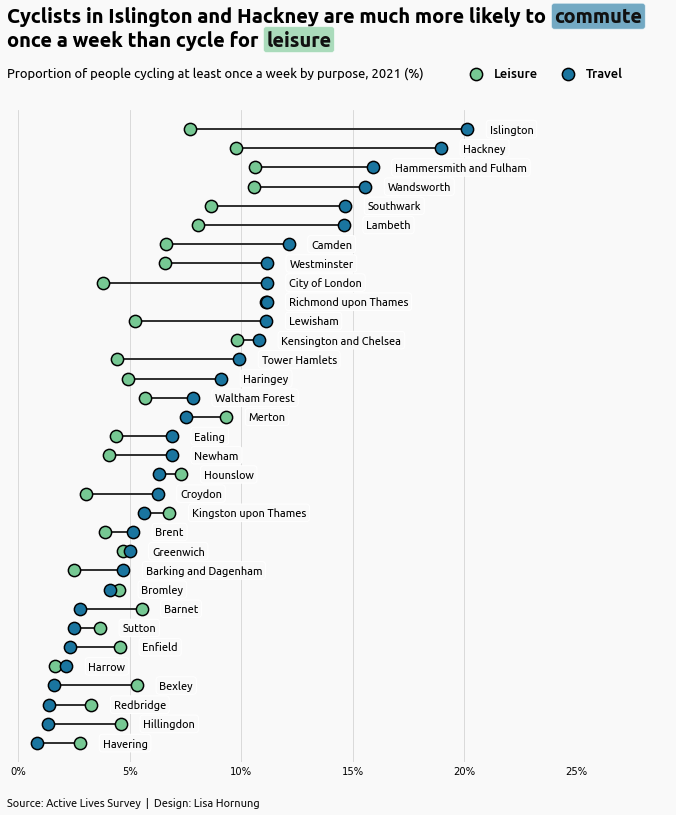

In [104]:
_filter = (df["Purpose"] != "Any")  & (df["ONS Code"].isin(pos_dict.keys())) & (df["Frequency"] == "At least once per week")
pivot = df[_filter].pivot(index="Area name", columns="Purpose", values="2021")
data = pivot.sort_values(by="Travel", ascending=True)

colr = {"Travel": "#1a759f", "Leisure":"#76c893"}

###plot
fig, ax = plt.subplots(figsize=(10,12), sharey=True)
#fig.set_facecolor("white")
fig.set_facecolor("#f9f9f9")

#dot plot
my_range = np.arange(len(data))
size = 150
plt.hlines(y=my_range, xmin=data['Leisure'], xmax=data['Travel'],linewidth=2, color='#333333', alpha=1, zorder=2)
plt.scatter(data['Leisure'], my_range, s=size, color=colr["Leisure"], linewidth=1.5, edgecolors='black', 
            alpha=1, label='Leisure', zorder=3)
plt.scatter(data['Travel'], my_range, s=size, color=colr["Travel"],linewidth=1.5, edgecolors='black', 
            alpha=1 , label='Travel', zorder=3)

#add borough names
for i in range(len(data)):
    plt.text(max(data[["Travel", "Leisure"]].iloc[i])+ 1, my_range[i], 
             data.index[i], ha='left', va='center', fontsize=11, fontproperties=font_r ,
            bbox=dict(facecolor='#f9f9f9', edgecolor='white', boxstyle='round'))
    
    
#xaxis
plt.gca().set_xlim(xmin=0, xmax=max(data[["Travel", "Leisure"]].max())+2)
plt.gca().get_xaxis().set_ticks([0, 5,10,15,20,25]) #remove ticks
plt.grid(visible=True, axis='x', zorder=1, color = "#D3D3D3", label=12)
plt.gca().xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}%'))
        
#yaxis
plt.gca().set_ylim(ymin=-1, ymax=len(data))
plt.tick_params(axis='both', length = 0, color = "#444444")
plt.gca().set_yticks([])


#remove frame
for pos in ["top", "bottom", "left", "right"]:
    plt.gca().spines[pos].set_visible(False)
plt.gca().set_facecolor("#f9f9f9")    
    
# ==========
#legend
L = ax.legend(ncol=2, frameon=False, loc='upper right',bbox_to_anchor=(1.1,1.08))
plt.setp(L.texts, fontproperties=font_m, fontsize=13)

#Title, footer, notes
plt.figtext(0.11,1.0, "Cyclists in Islington and Hackney are much more likely to                          \nonce a week than cycle for", 
            fontproperties=font_b, va='top', fontsize=20)
plt.figtext(0.87,1.0, "commute", color='#111111', fontproperties=font_b, va='top', fontsize=20,
           bbox=dict(facecolor=colr["Travel"], edgecolor='white', boxstyle='round', pad=0.15, alpha=0.6))
plt.figtext(0.47,0.973, "leisure", fontproperties=font_b, va='top', fontsize=20, color='#111111',
           bbox=dict(facecolor=colr["Leisure"], edgecolor='white', boxstyle='round', pad=0.15, alpha=0.6))
plt.figtext(0.11,0.93, "Proportion of people cycling at least once a week by purpose, 2021 (%)", 
            fontproperties=font_r, va='top', fontsize=13)
plt.figtext(0.11 ,0.085, "Source: Active Lives Survey  |  Design: Lisa Hornung",   
            fontproperties=font_r, color="#111111", fontsize=11, va="top")

#save output
plt.savefig("London-boroughs-cycling-rates-reason_2021.png", bbox_inches='tight', transparent=False, pad_inches=0.15)

plt.show()

## Choropleth map: by purpose

In [76]:
_filter = (df["Purpose"] != "Any")  & (df["ONS Code"].isin(pos_dict.keys())) & (df["Frequency"] == "At least once per week")
pivot = df[_filter].pivot(index="Area name", columns="Purpose", values="2021")
pivot["Point_diff"] = pivot["Travel"] - pivot["Leisure"]
pivot["Perc_diff"] = (pivot["Travel"] - pivot["Leisure"])/pivot["Leisure"]*100
pivot.head()

Purpose,Leisure,Travel,Point_diff,Perc_diff
Area name,,,,
Barking and Dagenham,2.503504,4.717105,2.213601,88.420140
Barnet,5.536387,2.790163,-2.746225,-49.603192
Bexley,5.336136,1.599701,-3.736435,-70.021358
Brent,3.878983,5.155689,1.276706,32.913414
Bromley,4.528229,4.125496,-0.402732,-8.893820


<AxesSubplot:>

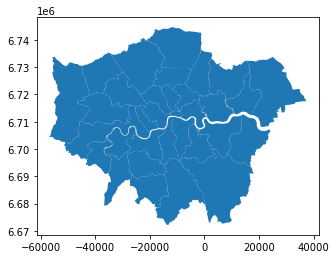

In [78]:
#load shapefile
fp = os.path.join(project_root, "raw_data\\London_Borough_Excluding_MHW.geojson")
map_df = gpd.GeoDataFrame.from_file(fp)

# join the geodataframe with the cleaned up csv dataframe
merged = map_df.set_index('NAME').join(pivot)
#print(merged.head())

map_df.plot()

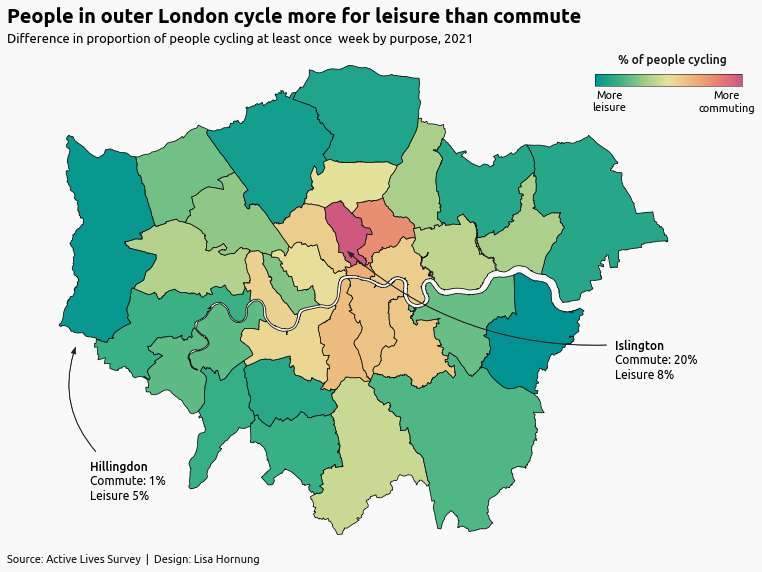

In [96]:
from palettable.cartocolors.diverging import Earth_7, TealRose_7, Temps_7
from palettable.colorbrewer.diverging import RdBu_10
from palettable.scientific.diverging import Broc_9, Cork_9, Vik_9

#input
variable = "Point_diff"
color = Temps_7

vmin, vmax = merged[variable].min(), merged[variable].max()
fig, ax = plt.subplots(figsize=(12,10))
fig.set_facecolor("#f9f9f9")

# create map
ax = merged.plot(column=variable, cmap=color.mpl_colormap, linewidth=0.8, ax=ax, edgecolor='#111111')
ax.axis('off')

#======
#colorbar
cbaxes = fig.add_axes([0.78, 0.8, 0.17, 0.017]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=color.mpl_colormap)                      
cb = plt.colorbar(cmappable, cax = cbaxes, anchor=(1,1.2), orientation='horizontal', drawedges=False,
            ticks=[0.1,  0.9])
cb.set_ticklabels(["More\nleisure","More\ncommuting" ], fontproperties=font_r, size=11, va='top')
cbaxes.tick_params(size=0)
cb.outline.set_linewidth(0.5)

#===========
#arrows and annotations
araxes = fig.add_axes([0.1, 0.2, 0.8, 0.6])
araxes.patch.set_alpha(0.01)
araxes.axis('off')

#define style
style = "Simple, tail_width=0.5, head_width=5, head_length=7"
kw = dict(arrowstyle=style, color="#222222")

#define arrows
a1 = patches.FancyArrowPatch((0.87, 0.4), (0.49, 0.62),linewidth=0.5,
                            connectionstyle="arc3,rad=-0.2", **kw, clip_on=False)
a2 = patches.FancyArrowPatch((0.13, 0.15), (0.1, 0.4),linewidth=0.5,
                            connectionstyle="arc3,rad=-.3", **kw, clip_on=False)

#add arrows to plot
for a in [a1, a2]:
    araxes.add_patch(a)

#text
araxes.text(0.88, 0.4, "Islington", fontproperties=font_m, size=12, va='center')
araxes.text(0.88, 0.35,"Commute: 20%\nLeisure 8%", fontproperties=font_r, size=12, va='center')

#text
araxes.text(0.12, 0.12, "Hillingdon", fontproperties=font_m, size=12, va='center')
araxes.text(0.12, 0.07,"Commute: 1%\nLeisure 5%", fontproperties=font_r, size=12, va='center')

#==========
#
plt.figtext(0.1,0.91, "People in outer London cycle more for leisure than commute", 
            fontproperties=font_b, va='top', fontsize=20)
plt.figtext(0.1,0.875, "Difference in proportion of people cycling at least once  week by purpose, 2021", 
            fontproperties=font_r, va='top', fontsize=13)
plt.figtext(0.1,0.15, "Source: Active Lives Survey  |  Design: Lisa Hornung",   
            fontproperties=font_r, color="#111111", fontsize=11, va="top")
plt.figtext(0.87,0.845, "% of people cycling",   
            fontproperties=font_m, color="#111111", fontsize=12, va="top", ha='center')

#save
plt.savefig("London-boroughs-cycling-rates-reason-map_2021.png", bbox_inches='tight', transparent=False, pad_inches=0.15)

plt.show()